<a href="https://colab.research.google.com/github/VMBoehm/ML_Lectures/blob/main/IntroductionToVariationalAutoencoders_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Introduction to Variational AutoEncoders (VAEs) and applications to physical data 

by Vanessa Boehm (UC Berkeley and LBNL)   
Feb 27 2022


---


In this notebook we will be implementing our first Variational Autoencoder. VAEs are a useful tool for the analysis of physical data because of their probabilistic layout.   

We will start from a (non-probalistic) autoencoder and convert it into its variational counterpart.

## Autoencoder

Recall that an Auto-Encoder consists of two networks: 

1.   An encoder network that takes the data, $x$, and maps it to a lower-dimensional latent space. We will call this network $f$ and its network parameters $\phi$.
2.   A decoder network that takes the encoded data, $z$, and maps it back to the data space. We will call the result of the reconstruction $x'$, the decoder network $g$ (for generator) and its network parameters $\psi$.

$$ x' = g_\psi(f_\phi(x)) \tag{1}$$

An Auto-Encoder is trained to minimize the reconstruction error between the input $x$ and the reconstruction $x'$.

$$ \mathcal{L}_{AE}(\phi,\psi) = ||x-g_\psi(f_\phi(x))||^2_2 \tag{2}$$

---

## Probabilistic Interpretation

**In a Variational Auto-Encoder we interpret the reconstruction task  probabilistically:**

Compressing the data results in a loss of information about the original data. 
If we only have access to the compressed data, we have no chance of knowing what the original data looked like *exactly*. Instead, we obtain a probability distribution over possible inputs.

$$ p(x) = \int \mathrm{d}z\, p(x|z) p(z) \tag{3}$$

Here, we have introduced two probability distributions on the right hand side, the liklelihood, $p(x|z)$, and the prior, $p(z)$.

The likelihood arises because of the information loss in the compression.

$$ x = g_\psi(f_\phi(x)) + \epsilon = g_\psi(z) + \epsilon \tag{4}$$ 

Ideally, $\epsilon$, the part of the data that is lost in the compression, is just noise and unimportant for our final data analysis. The form of the likelihood is equal to the distribution of this noise. For example, if the noise is Gaussian (which is often the case for physical data) with covariance $\Sigma_\epsilon$, the likelihood is a Gaussian distribution:

$$ p_{\psi}(x|z) = \mathcal{G}(g_\psi(z),\Sigma_\epsilon) \tag{5}$$ 

**Optional Question 1**   
Starting from $p(x|z) = \int \mathrm{d}\epsilon\, p(x,\epsilon|z)$ can you show that the likelihood follows the same distribution as $\epsilon$?

Solution:
$p(x|z) = \int \mathrm{d}\epsilon\, p(x,\epsilon|z) = \int \mathrm{d}\epsilon\, p(x|z,\epsilon) p(\epsilon) = \int \mathrm{d}\epsilon\, \delta_D(x-g(z)-\epsilon) p(\epsilon) = p(x-g(z))$ 

The prior, $p(z)$, is the average distribution of the encoded data.

$$ p(z) = \int \mathcal{d}x\, p(z|x) p(x) \tag{6}$$

In a VAE, we want the prior distribution to have closed form and to be easy to sample from (for artificial data generation). We have the freedom to choose the prior distribution as a constraint. The network training will ensure it is obeyed. A common choice is a normal distribution

$$ p(z) = \mathcal{N}(0,1) \tag{7} $$

---

### VAE training & Evidence Lower BOund (ELBO)

To train the Variational Auto-Encoder we maximize the average log probability, $\log p(x)$, or, as we will see now, a lower bound to this quantity.

Equation (3) involves solving a fairly high dimensional integral, which is a computationally expensive and sometimes infeasible operation. This integral has to be solved not only once, but in each training step. Variational Autoencoders  solve this integral approximately by using a variational ansatz for the posterior distribution, the approximate posterior $q_\phi(z|x)$. This distribution approximates the true posterior p(z|x) and is parameterized by the encoder parameters $\phi$. 

The classic choice for the variational posterior is a multivariate Gaussian in the mean field approxiation (mean field meaning no off-diagonal terms in the covariance)

$$ q_\phi(z|x) = \mathcal{G}(\mu,\sigma_i) \tag{7} $$

where the mean, $\mu$, and variance, $\sigma$, are determined by the encoder network. 

$$(\mu, \sigma) = f_\phi(x) \tag{8} $$

As we saw in the lecture, the variational ansatz allows us to formulate a lower bound to $\log p(x)$, the Evidence Lower BOund.

$$ \log p(x) >= \int \mathrm{d}z\, q_\phi(z|x) \log{p_\psi(x|z)} - \int \mathrm{d}z\, q_\phi(z|x) \log{\frac{q_\phi(z|x)}{p(z)}} = ELBO \tag{8}$$

$$ \mathcal{L}_{VAE}(\phi,\psi) = -ELBO \tag{9}$$

The ELBO consists of two terms. The first term measures the expectation value of the likelihood over the posterior. Maximizing this term encourages high quality reconstructions (similar to the autoencoder). The second term is the KL-Divergence (a distance measure) between the variational posterior and the prior. This term acts as a regularizer. It encourages posterior distributions which are similar to the prior.

In VAE training the first term is evaluated stochastically, meaning that the expectation value is evaluated approximately by averaging over a number of samples from $q_\phi(z|x)$. The second term can be either evaluated analytically (the KL divergence between to Gaussian distributions can be calculated) or stochastically. 

---

### Reparametrization Trick

Minimizing Eq. (9) requires taking gradients with respect to $\phi$ and $\psi$. But how do we take the gradient through an expectation value?  

We use what is called the reparametrization trick. Instead of sampling from the posterior $q_\phi(z|x)$ we sample from the parameter-independent normal distribution

$$ \zeta ∼ \mathcal{N}(0,1) \tag{10}$$

and use the $z=\zeta*\sigma_\phi+\mu_\phi$, an operation which is trivially differentiably, to obtain our samples.

Pytorch will perform the reparametrization trick for us under the hood, so that we don't have to code it explicitly.


### Data

In this coding exercise we will be working with a galaxy spectra sample from the SDSS-BOSS DR 16 release. The spectra have been de-redshifted to the restframe and their magnitude has been standardized to a distance correspondingg to $z_\lambda=0.01$. They have further been downsampled to 1000 pixels, denoised and inpainted where masks were present.

(I can tell you more about the data cuts and preprocessing if you are interested, but it is not relevant for this task.)

Despite being relatively high-dimensional ($d=1000$), galaxy specrtra actually reside on a lower dimensional manifold since we can compress them to much smaller dimensionality without sacrificing much reconstruction quality. 

This property makes them a very suitable data type for VAEs. 

(The same applies to image data, but images datasets are computationally more expensive to train on and they need more complicated nework architectures - things that we don't want to worry about for this exercise.)

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! ls drive/MyDrive/ML_lecture_data/

DR16_denoised_inpainted.npy


In [4]:
BATCHSIZE       = 64
BATCHSIZE_VALID = 64

INPUT_SIZE      = 1000
LATENT_SIZE     = 10

LEARNING_RATE   = 1e-3

In [5]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class SDSS_DR16(Dataset):
    """De-redshifted and downsampled spectra from SDSS-BOSS DR16"""

    def __init__(self, root_dir='drive/MyDrive/ML_lecture_data/', transform=True, train=True):
        """
        Args:
            root_dir (string): Directory of data file
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        if train:
            self.data, _ = np.load(open(os.path.join(root_dir,'DR16_denoised_inpainted.npy'),'rb'),allow_pickle=True)
            self.data = self.data[0:50000]
        else:
            _, self.data = np.load(open(os.path.join(root_dir,'DR16_denoised_inpainted.npy'),'rb'),allow_pickle=True)
            self.data = self.data[0:10000]

        self.data = torch.as_tensor(self.data)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]

        return sample




training_data = SDSS_DR16(train=True)
valid_data    = SDSS_DR16(train=False)

train_dataloader = DataLoader(training_data, batch_size=BATCHSIZE, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCHSIZE_VALID, shuffle=True)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):

    def __init__(self, seed=853):
        super(Encoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(INPUT_SIZE,200)
        self.fc2 = nn.Linear(200,LATENT_SIZE)


    def forward(self, x):
        x = torch.nn.LeakyReLU()(self.fc1(x))
        z = self.fc2(x)
        return z

class Decoder(nn.Module):

    def __init__(self, seed=620):
        super(Decoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(LATENT_SIZE,200)
        self.fc2 = nn.Linear(200,INPUT_SIZE)


    def forward(self, z):
        z = torch.nn.LeakyReLU()(self.fc1(z))
        x = self.fc2(z)
        return x

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x


In [8]:
AE = Autoencoder()

In [11]:
loss_fn   = nn.MSELoss()
optimizer = torch.optim.Adam(AE.parameters(), lr=LEARNING_RATE)


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, X in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred,X)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    return loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    test_loss /= num_batches
    print(f" Avg loss: {test_loss:>8f} \n")

    return test_loss


In [12]:
epochs = 10

train_loss = []
test_loss  = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, AE, loss_fn, optimizer))
    test_loss.append(test_loop(valid_dataloader, AE, loss_fn))
print("Done!")

Epoch 1
-------------------------------
loss: 0.013688  [    0/50000]
 Avg loss: 0.009775 

Epoch 2
-------------------------------
loss: 0.011117  [    0/50000]
 Avg loss: 0.009813 

Epoch 3
-------------------------------
loss: 0.008906  [    0/50000]
 Avg loss: 0.007371 

Epoch 4
-------------------------------
loss: 0.002164  [    0/50000]
 Avg loss: 0.011823 

Epoch 5
-------------------------------
loss: 0.004663  [    0/50000]
 Avg loss: 0.017648 

Epoch 6
-------------------------------
loss: 0.009645  [    0/50000]
 Avg loss: 0.006992 

Epoch 7
-------------------------------
loss: 0.005620  [    0/50000]
 Avg loss: 0.010145 

Epoch 8
-------------------------------
loss: 0.006997  [    0/50000]
 Avg loss: 0.007257 

Epoch 9
-------------------------------
loss: 0.018934  [    0/50000]
 Avg loss: 0.005551 

Epoch 10
-------------------------------
loss: 0.005218  [    0/50000]
 Avg loss: 0.006143 

Done!


RuntimeError: ignored

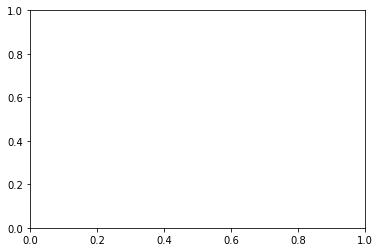

In [13]:
plt.figure()
plt.plot(train_loss)
plt.plot(test_loss)
plt.show()